In [1]:
catName = 'high'

In [2]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
cat = categories[catName]

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 7*' ' + 'Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [4]:
m_mu = 0.1056583755
m_pi = 0.13957062
m_K = 0.493677
m_D0 = 1.86483
m_Dst = 2.01026
m_jpsi = 3.096916
dm = m_Dst - m_D0

In [5]:
(m_D0**2-m_K**2-m_pi**2)/m_D0**2

0.9243163029587738

In [6]:
(m_Dst**2-m_D0**2-m_pi**2)/m_Dst**2

0.13463371017492218

In [7]:
catText = rt.TLatex()
catText.SetTextAlign(31)
catText.SetTextSize(0.06)
catText.SetTextFont(42)
catText.SetTextSize(0.05)

In [8]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [9]:
n = '../data/cmsRD/skimmed/B2DstMu_B0_201101'
dfRDB0_bare = pd.DataFrame(rtnp.root2array(n+'_{}_bare.root'.format(cat.name)))
dfRDB0_corr = pd.DataFrame(rtnp.root2array(n+'_{}_corr.root'.format(cat.name)))

n = '../data/cmsRD/skimmed/B2DstMu_antiB0_201122'
dfRDB0bar_bare = pd.DataFrame(rtnp.root2array(n+'_{}_bare.root'.format(cat.name)))
dfRDB0bar_corr = pd.DataFrame(rtnp.root2array(n+'_{}_corr.root'.format(cat.name)))

dfRD_bare = pd.concat([dfRDB0_bare, dfRDB0bar_bare])
dfRD_corr = pd.concat([dfRDB0_corr, dfRDB0bar_corr])

In [10]:
dataDir = '../data/cmsRD'
datasets_loc = glob(dataDir + '/ParkingBPH*/*2018*B2DstMu_200515*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu12_IP6_part2_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu12_IP6_part1_v2 5.3
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu12_IP6_part4_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu12_IP6_part3_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200515
HLT_Mu12_IP6_part0_v2 5.24
Total lumi: 26.41 fb^-1


In [11]:
loc = '../data/cmsMC_private/'
loc += 'BP_Tag_B0_MuNuDmst_Hardbbbar_evtgen_ISGW2_PUc0_10-2-3/'
loc += 'ntuples_B2DstMu/skimmed/{}'.format(cat.name)
dfMC_bare = pd.DataFrame(rtnp.root2array(loc+'_bare.root'))
dfMC_corr = pd.DataFrame(rtnp.root2array(loc+'_corr.root'))

In [12]:
'  '.join(dfMC_bare.columns)

'index  q2  Est_mu  M2_miss  U_miss  q2_coll  Est_mu_coll  M2_miss_coll  mu_pt  mu_eta  mu_phi  mu_sigdxy  mu_dca_vtxDst  mu_sigdca_vtxDst  mu_dcaT_vtxDst  mu_sigdcaT_vtxDst  mu_dca_vtxDstMu  mu_sigdca_vtxDstMu  mu_dcaT_vtxDstMu  mu_sigdcaT_vtxDstMu  B_pt  B_eta  B_phi  Dst_pt  Dst_eta  Dst_phi  D0_pt  D0_eta  D0_phi  pi_pt  pi_eta  pi_phi  K_pt  K_eta  K_phi  pval_piK  sigdxy_vtxD0_PV  pis_pt  pis_eta  pis_phi  pval_D0pis  mass_piK  mass_D0pis  mass_D0pismu  mass_D0pismu_muASpi  mass_D0pismu_muASK  D0pismu_eta  D0pismu_phi  pval_D0pismu  chi2_D0pismu  d_vtxD0pismu_PV  dxy_vtxD0pismu_PV  cos_D0pismu_PV  cosT_D0pismu_PV  N_goodAddTks  tkCharge_0  tkCharge_1  tkCharge_2  tkPt_0  tkPt_1  tkPt_2  tkPtError_0  tkPtError_1  tkPtError_2  tkEta_0  tkEta_1  tkEta_2  tkPhi_0  tkPhi_1  tkPhi_2  tkMassVis_0  tkMassVis_1  tkMassVis_2  tkMassHad_0  tkMassHad_1  tkMassHad_2  tkMassMuTk_0  tkMassMuTk_1  tkMassMuTk_2  tkMassMiss2_0  tkMassMiss2_1  tkMassMiss2_2  tkUmiss_0  tkUmiss_1  tkUmiss_2  massVis

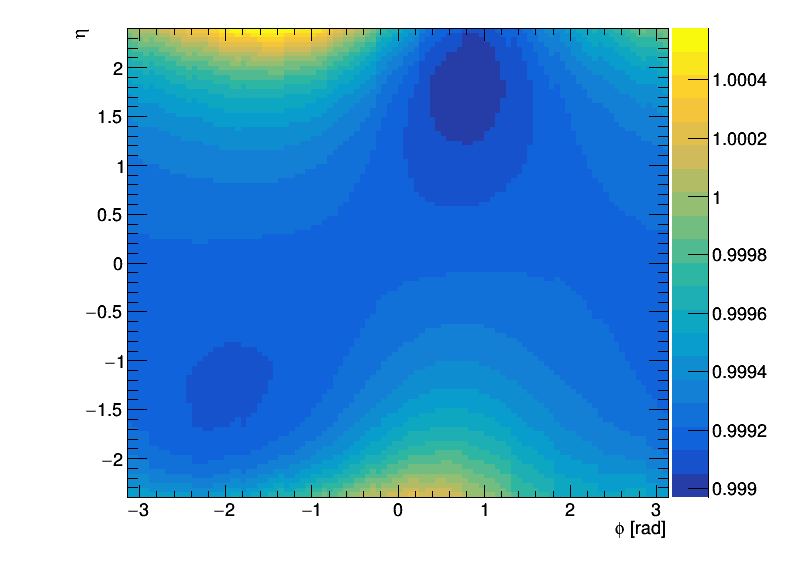

In [13]:
fBfield = rt.TFile.Open('../data/calibration/bFieldMap_2Dover3D.root', 'r')
hBfield = fBfield.Get('bfieldMap')
def get_bFieldCorr3D(phi, eta, verbose=False):
    if not verbose:
        idx = hBfield.GetBin(hBfield.GetXaxis().FindBin(phi), hBfield.GetYaxis().FindBin(eta))
        return 1./hBfield.GetBinContent(idx)
hBfield.SetXTitle('#phi [rad]')
hBfield.SetYTitle('#eta')
c = rt.TCanvas('c', 'c', 800, 600)
c.SetRightMargin(0.16)
hBfield.Draw('colz')
c.Draw() 
c.SaveAs('../data/calibration/trackCorrections/fig/magneticFieldRatioMap.png')

In [14]:
def compute_mR(dset, sp1='pi', sp2='K', m1=m_pi, m2=m_K, M=m_D0, scalePt=1., shiftE=[0,0], relSmear=0):
    if relSmear:
        sm1 = relSmear*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    E1 = np.hypot(m1, scalePt * dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    E2 = np.hypot(m2, scalePt * dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    mR = np.square(m1)*E2/E1
    mR += np.square(m2)*E1/E2
    mR /= M
    return mR

In [15]:
def compute_rC(dset, sp1='pi', sp2='K', m1=m_pi, m2=m_K, M=m_D0, scalePt=1., shiftE=[0,0], relSmear=0):
    if relSmear:
        sm1 = relSmear*np.random.randn(dset[sp1+'_pt'].shape[0]) + 1.
        sm2 = relSmear*np.random.randn(dset[sp2+'_pt'].shape[0]) + 1.
    else:
        sm1 = 1.
        sm2 = 1.
    
    q2 = np.square(M) - np.square(m1) - np.square(m2)
    E1 = np.hypot(m1, scalePt * dset[sp1+'_pt'] * sm1 * np.cosh(dset[sp1+'_eta'])) + shiftE[0]
    P1 = np.sqrt(np.square(E1) - np.square(m1))
    E2 = np.hypot(m2, scalePt * dset[sp2+'_pt'] * sm2 * np.cosh(dset[sp2+'_eta'])) + shiftE[1]
    P2 = np.sqrt(np.square(E2) - np.square(m2))
    
    rC_1 = E1*(E2/E1 + 0.5*(q2-2*E1*E2)/np.square(P1))/M
    rC_2 = E2*(E1/E2 + 0.5*(q2-2*E1*E2)/np.square(P2))/M
    return np.column_stack((rC_1, rC_2))

In [16]:
def getAvg(mass):
    m = np.mean(mass)
    s = np.std(mass)
    return [m, s/np.sqrt(mass.shape[0])]

# General plots

In [17]:
def drawVar(varRD, varMC,
            varRDcorr=None, varMCcorr=None,
            binning=None, xtitle='', legLoc=[0.18, 0.7, 0.4, 0.93], opt='overflow+underflow',
            meanInLeg=False, widthInLeg=False, cTag=''
           ):
    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    hRD = create_TH1D(varRD, 'RDbare',
                      binning=binning, 
                      axis_title=[xtitle, 'Normalized candidates'],
                      scale_histo='norm',
                      opt=opt
                     )
    s = 'data'
    if not (varRDcorr is None):
        s += ' bare'
    if meanInLeg: s += ', Avg: {:.2f}'.format(np.mean(varRD))
    if widthInLeg: 
        s = '#splitline{'+s+'}{'
        bin1 = hRD.FindFirstBinAbove(hRD.GetMaximum()/2)
        bin2 = hRD.FindLastBinAbove(hRD.GetMaximum()/2)
        fwhm = hRD.GetBinCenter(bin2) - hRD.GetBinCenter(bin1)
        s += 'FWHM: {:.3f}'.format(fwhm)+'}'
    leg.AddEntry(hRD, s, 'lep')

    hMC = create_TH1D(varMC, 'MCbare', binning=hRD.binning, opt=opt, scale_histo='norm')
    hMC.SetLineColor(col_dic['mu'])
    s = label_dic['mu']
    if meanInLeg: s += ', Avg: {:.2f}'.format(np.mean(varMC))
    if widthInLeg: 
        s = '#splitline{'+s+'}{'
        bin1 = hMC.FindFirstBinAbove(hMC.GetMaximum()/2)
        bin2 = hMC.FindLastBinAbove(hMC.GetMaximum()/2)
        fwhm = hMC.GetBinCenter(bin2) - hMC.GetBinCenter(bin1)
        s += 'FWHM: {:.3f}'.format(fwhm)+'}'
    leg.AddEntry(hMC, s, 'lep')
    h_list = [hRD, hMC]
    
    if not varRDcorr is None:
        hRDc = create_TH1D(varRDcorr, 'RDcorr', binning=hRD.binning, scale_histo='norm', opt=opt)
        hRDc.SetLineColor(1)
        hRD.SetLineColor(rt.kGray)
        h_list.append(hRDc)
        leg.AddEntry(hRDc, 'data corr', 'lep')
        
    if not varMCcorr is None:
        hMCc = create_TH1D(varMCcorr, 'MCcorr', binning=hRD.binning, scale_histo='norm', opt=opt)
        hMCc.SetLineColor(col_dic['mu'])
        hMC.SetLineColor(col_dic['mu']-10)
        h_list.append(hMCc)
        leg.AddEntry(hMCc, label_dic['mu']+' corr', 'lep')
        
    
    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same', mB=0.15, tag=cTag)
    leg.Draw()
    catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
    c.dnd = h_list + [leg]
    return c

In [18]:
def draw_dM_vs_x(m_piK_RD, m_piK_MC, m_piK_RDcorr, xRD, xMC, xRDcorr, bins=None, xlabel=''):
    avgRD = []
    avgRDcorr = []
    avgMC = []

    for i in range(len(bins)-1):
        m = bins[i]
        M = bins[i+1]   
        selRD = np.logical_and(xRD>m, xRD<M)
        avgRD.append(getAvg(m_piK_RD[selRD]))
        
        if not m_piK_RDcorr is None:
            selRD = np.logical_and(xRDcorr>m, xRDcorr<M)
            avgRDcorr.append(getAvg(m_piK_RDcorr[selRD]))

        selMC = np.logical_and(xMC>m, xMC<M)
        avgMC.append(getAvg(m_piK_MC[selMC]))

    avgRD = 1e3*np.array(avgRD)
    if not m_piK_RDcorr is None:
        avgRDcorr = 1e3*np.array(avgRDcorr)
    avgMC = 1e3*np.array(avgMC)

    x = (bins[1:] + bins[:-1])/2.
    dx = (bins[1:] - bins[:-1])/2.

    plt.rcParams.update({'font.size': 18})
    f = plt.figure(figsize=(8,6))
    c = 'black' if m_piK_RDcorr is None else 'gray'
    plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='data bare', color=c)
    if not m_piK_RDcorr is None:
        plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='data corr', color='black')
    plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC', color='deepskyblue')
    plt.xlabel(xlabel)
    plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
    plt.legend(loc='best', numpoints=1)
    plt.grid()

# Pre-correction plots

In [19]:
def drawVar_beginning(varB0, varB0bar, varMC,
            binning=None, xtitle='', legLoc=[0.18, 0.7, 0.4, 0.93], opt='',
            meanInLeg=False, widthInLeg=False, cTag=''
           ):
    leg = rt.TLegend(legLoc[0], legLoc[1], legLoc[2], legLoc[3])
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    hRD1 = create_TH1D(varB0, 'hB0',
                      binning=binning, 
                      axis_title=[xtitle, 'Normalized candidates'],
                      scale_histo='norm',
                      opt=opt
                     )
    hRD1.SetLineColor(2)
    s = 'data D*^{-}#mu^{+}'
    if meanInLeg: s += ', Avg: {:.2f}'.format(np.mean(hRD1))
    if widthInLeg: 
        s = '#splitline{'+s+'}{'
        bin1 = hRD1.FindFirstBinAbove(hRD1.GetMaximum()/2)
        bin2 = hRD1.FindLastBinAbove(hRD1.GetMaximum()/2)
        fwhm = hRD1.GetBinCenter(bin2) - hRD1.GetBinCenter(bin1)
        s += 'FWHM: {:.3f}'.format(fwhm)+'}'
    leg.AddEntry(hRD1, s, 'lep')
    
    
    hRD2 = create_TH1D(varB0bar, 'hB0Bar',
                      binning=binning,
                      scale_histo='norm',
                      opt=opt
                     )
    hRD2.SetLineColor(4)
    s = 'data D*^{+}#mu^{-}'
    if meanInLeg: s += ', Avg: {:.2f}'.format(np.mean(hRD2))
    if widthInLeg: 
        s = '#splitline{'+s+'}{'
        bin1 = hRD2.FindFirstBinAbove(hRD2.GetMaximum()/2)
        bin2 = hRD2.FindLastBinAbove(hRD2.GetMaximum()/2)
        fwhm = hRD2.GetBinCenter(bin2) - hRD2.GetBinCenter(bin1)
        s += 'FWHM: {:.3f}'.format(fwhm)+'}'
    leg.AddEntry(hRD2, s, 'lep')

    hMC = create_TH1D(varMC, 'MCbare', binning=hRD1.binning, opt=opt, scale_histo='norm')
    hMC.SetLineColor(1)
    s = label_dic['mu']
    if meanInLeg: s += ', Avg: {:.2f}'.format(np.mean(varMC))
    if widthInLeg: 
        s = '#splitline{'+s+'}{'
        bin1 = hMC.FindFirstBinAbove(hMC.GetMaximum()/2)
        bin2 = hMC.FindLastBinAbove(hMC.GetMaximum()/2)
        fwhm = hMC.GetBinCenter(bin2) - hMC.GetBinCenter(bin1)
        s += 'FWHM: {:.3f}'.format(fwhm)+'}'
    leg.AddEntry(hMC, s, 'lep')
    
    h_list = [hRD1, hRD2, hMC]    
    SetMaxToMaxHist(h_list)
    c = drawOnCMSCanvas(CMS_lumi, h_list, 'same', mB=0.15, tag=cTag)
    leg.Draw()
    catText.DrawLatexNDC(0.95, 0.85, 'Category: {}'.format(cat.name))
    c.dnd = h_list + [leg]
    return c

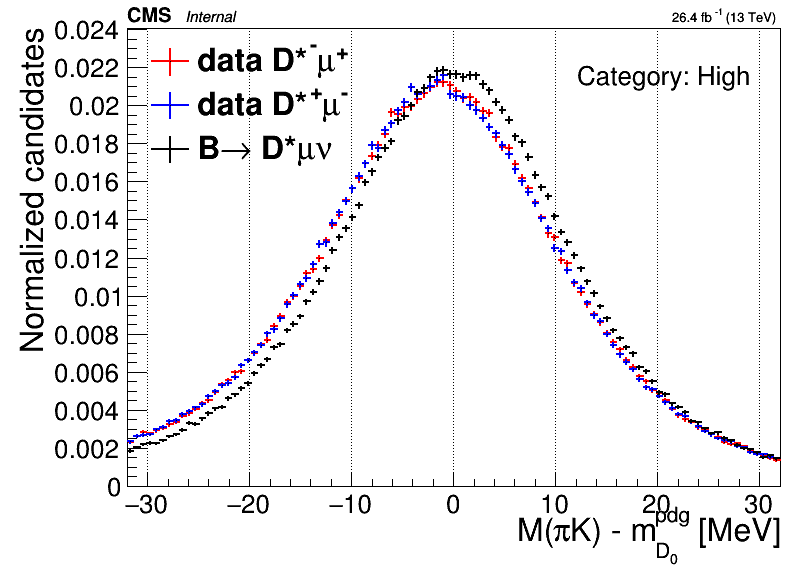

In [20]:
C = drawVar_beginning(
            varB0=1e3*(dfRDB0_bare['mass_piK'] - m_D0), 
            varB0bar=1e3*(dfRDB0bar_bare['mass_piK'] - m_D0), 
            varMC=1e3*(dfMC_bare['mass_piK'] - m_D0),
            binning=[100, -32, 32], 
            xtitle='M(#piK) - m_{D_{0}}^{pdg} [MeV]',
            legLoc=[0.18, 0.7, 0.45, 0.93],
            meanInLeg=False, widthInLeg=False
           )
C.SetGridx()
C.SaveAs('../data/calibration/trackCorrections/fig/mD0_pre_{}.png'.format(cat.name))

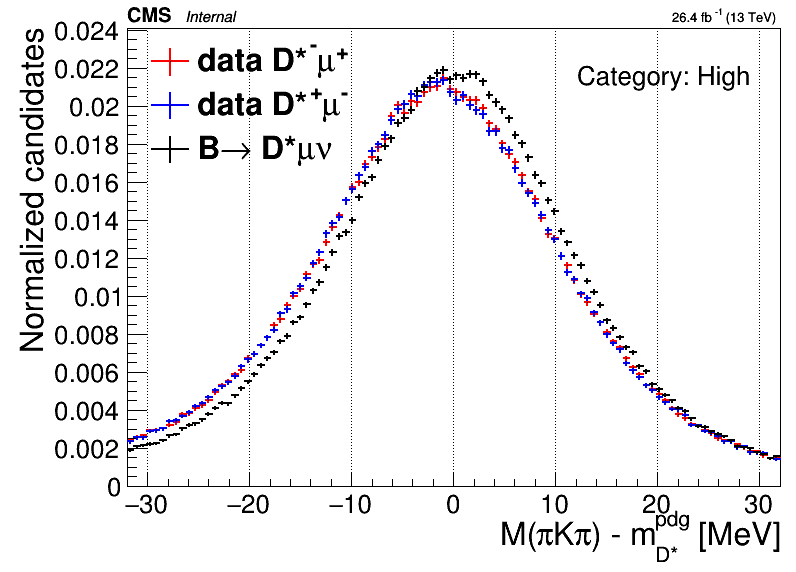

In [21]:
C = drawVar_beginning(
            varB0=1e3*(dfRDB0_bare['mass_D0pis'] - m_Dst), 
            varB0bar=1e3*(dfRDB0bar_bare['mass_D0pis'] - m_Dst), 
            varMC=1e3*(dfMC_bare['mass_D0pis'] - m_Dst),
            binning=[100, -32, 32], 
            xtitle='M(#piK#pi) - m_{D*}^{pdg} [MeV]',
            legLoc=[0.18, 0.7, 0.45, 0.93],
            meanInLeg=False, widthInLeg=False
           )
C.SetGridx()
C.SaveAs('../data/calibration/trackCorrections/fig/mDst_pre_{}.png'.format(cat.name))

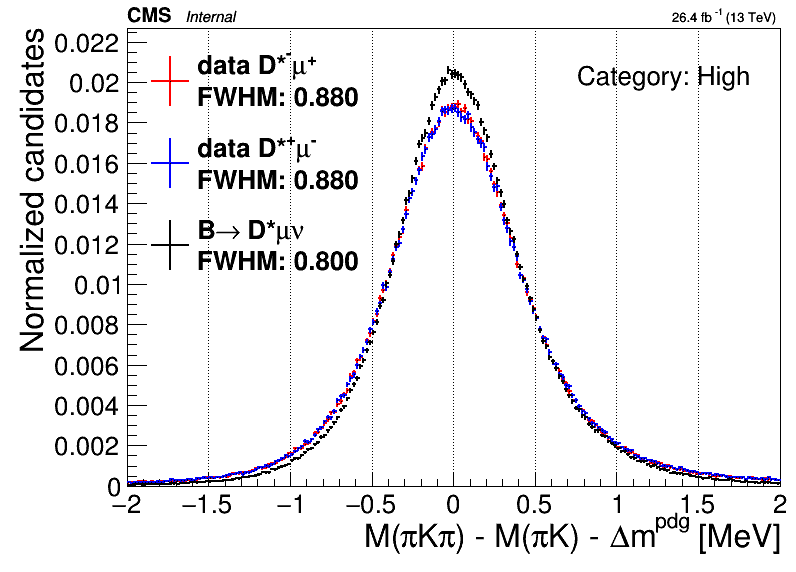

In [22]:
C = drawVar_beginning(
            varB0=1e3*(dfRDB0_bare['mass_D0pis'] - dfRDB0_bare['mass_piK'] - m_Dst + m_D0),
            varB0bar=1e3*(dfRDB0bar_bare['mass_D0pis'] - dfRDB0bar_bare['mass_piK'] - m_Dst + m_D0),
            varMC=1e3*(dfMC_bare['mass_D0pis'] - dfMC_bare['mass_piK'] - m_Dst + m_D0),
            binning=[200, -2., 2], 
            xtitle='M(#piK#pi) - M(#piK) - #Deltam^{pdg} [MeV]',
            legLoc=[0.18, 0.5, 0.45, 0.93],
            meanInLeg=False, widthInLeg=True
           )
C.SetGridx()
C.SaveAs('../data/calibration/trackCorrections/fig/dm_pre_{}.png'.format(cat.name))

# Corrections

Corrections are pre-applyied

# Observables Masses

In [23]:
m_piK_RDcorr = dfRD_corr['mass_piK']

In [24]:
m_piK_MCcorr = dfMC_corr['mass_piK']

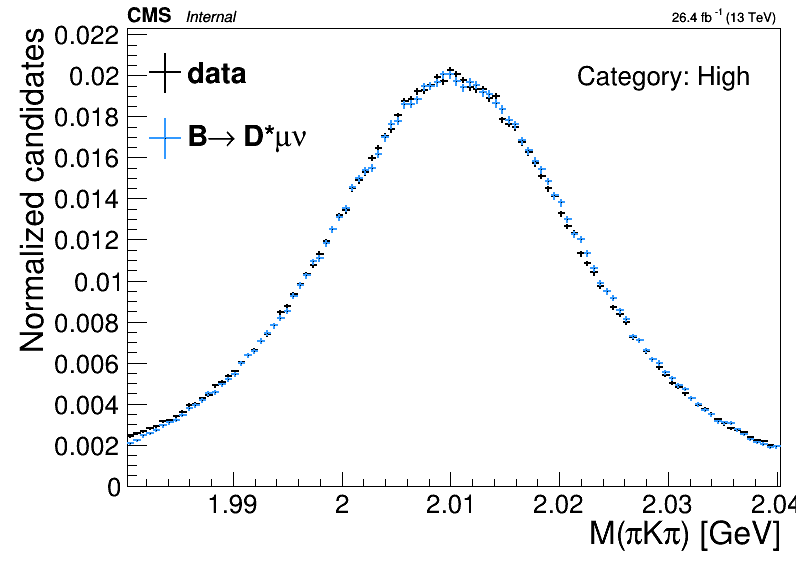

In [25]:
C = drawVar(varRD=dfRD_corr['mass_D0pis'],
            varMC=dfMC_corr['mass_D0pis'],
            binning=[100, m_Dst-0.03, m_Dst+0.03], opt='',
            xtitle='M(#piK#pi) [GeV]')

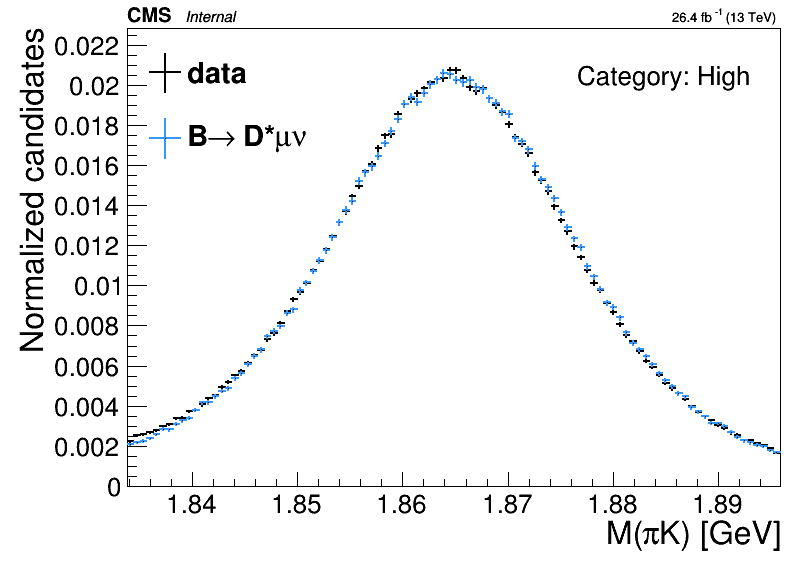

In [26]:
C = drawVar(varRD=m_piK_RDcorr, 
            varMC=m_piK_MCcorr,
            binning=[100, m_D0-0.031, m_D0+0.031], opt='',
            xtitle='M(#piK) [GeV]')

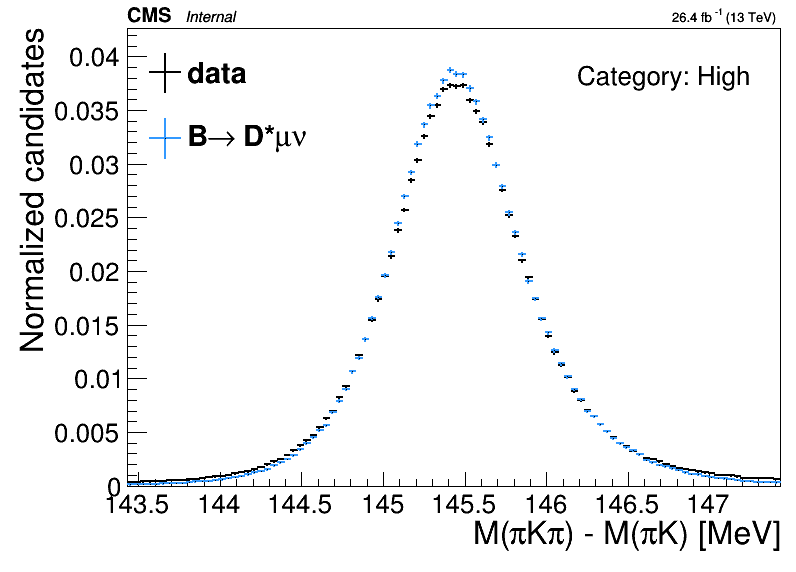

In [27]:
C = drawVar(varRD=1e3*(dfRD_corr['mass_D0pis'] - dfRD_corr['mass_piK']),
            varMC=1e3*(dfMC_corr['mass_D0pis'] - dfMC_corr['mass_piK']),
            binning=[100, 1e3*dm - 2, 1e3*dm + 2], 
            xtitle='M(#piK#pi) - M(#piK) [MeV]')

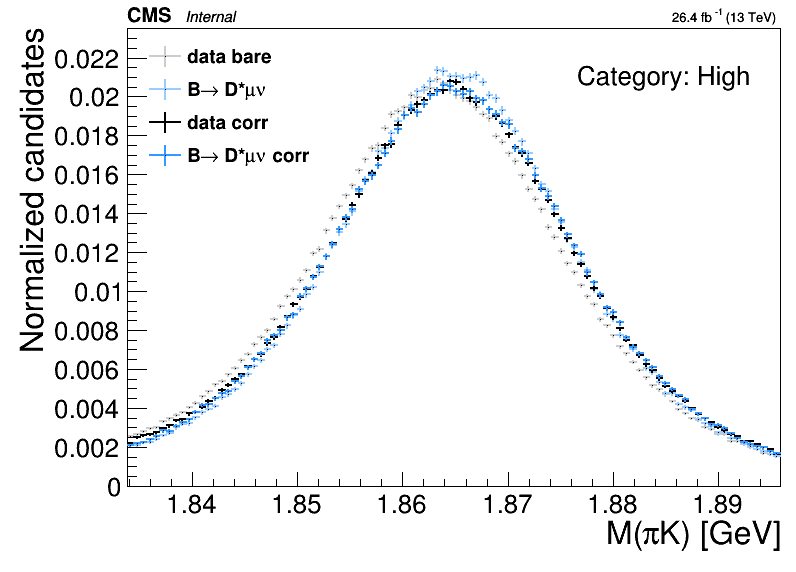

In [28]:
C = drawVar(varRD=dfRD_bare['mass_piK'], 
            varMC=dfMC_bare['mass_piK'],
            varRDcorr=m_piK_RDcorr,
            varMCcorr=m_piK_MCcorr,
            binning=[100, m_D0-0.031, m_D0+0.031],  opt='',
            xtitle='M(#piK) [GeV]')
C.SaveAs('../data/calibration/trackCorrections/fig/mD0_post_{}.png'.format(cat.name))

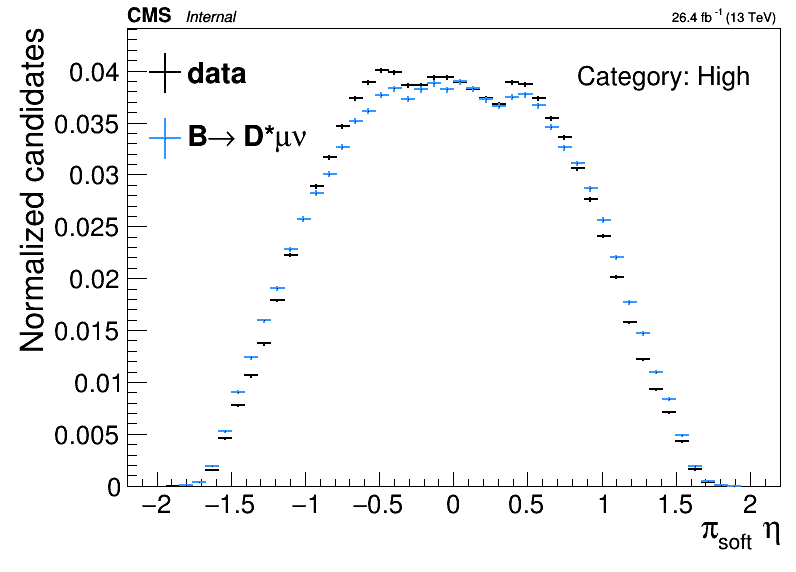

In [29]:
for p in [['K', 'K'], ['pi','#pi'], ['pis', '#pi_{soft}']]:
    C = drawVar(varRD=dfRD_bare[p[0]+'_eta'], 
                varMC=dfMC_bare[p[0]+'_eta'],
                binning=[50, -2.2, 2.2], 
                xtitle=p[1]+' #eta')
    C.SaveAs('../data/calibration/trackCorrections/fig/eta_'+p[0]+'_pre_{}.png'.format(cat.name))

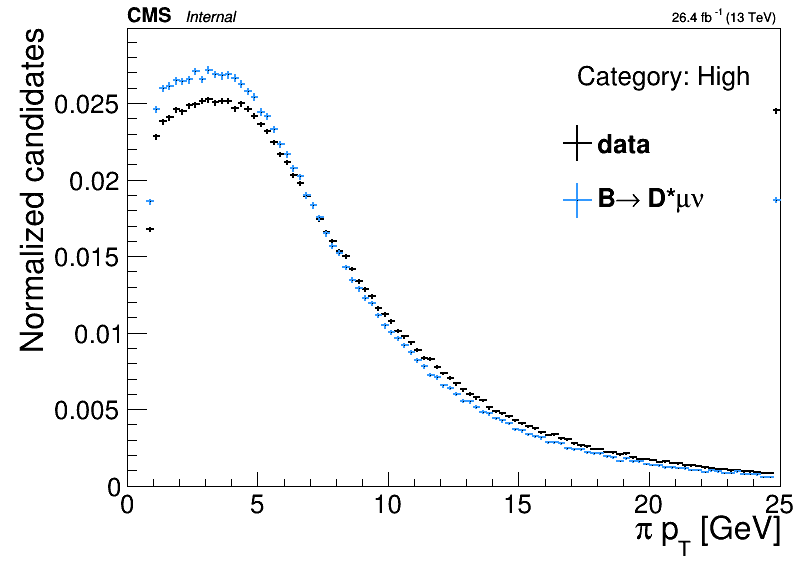

In [30]:
C = drawVar(varRD=dfRD_bare['pi_pt'], 
            varMC=dfMC_bare['pi_pt'],
#             varRDcorr=dfRD_corr['pi_pt'],
#             varMCcorr=dfMC_corr['pi_pt'],
#             opt='',
            binning=[100, 0, 25], 
            xtitle='#pi p_{T} [GeV]', 
            legLoc=[0.7, 0.6, 0.9, 0.8])
C.SaveAs('../data/calibration/trackCorrections/fig/pt_pi_pre_{}.png'.format(cat.name))

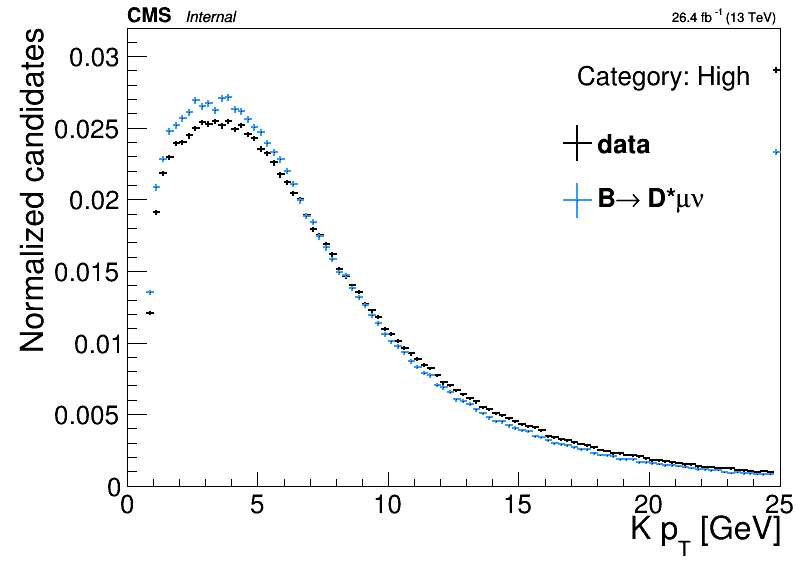

In [31]:
C = drawVar(varRD=dfRD_bare['K_pt'], 
            varMC=dfMC_bare['K_pt'],
#             varRDcorr=dfRD_corr['pi_pt'],
#             varMCcorr=dfMC_corr['pi_pt'],
#             opt='',
            binning=[100, 0, 25], 
            xtitle='K p_{T} [GeV]', 
            legLoc=[0.7, 0.6, 0.9, 0.8])
C.SaveAs('../data/calibration/trackCorrections/fig/pt_K_pre_{}.png'.format(cat.name))

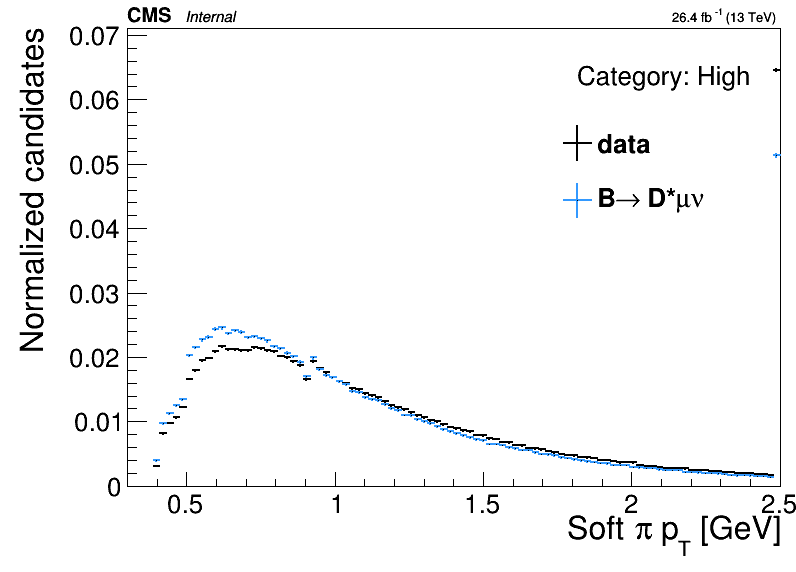

In [32]:
C = drawVar(varRD=dfRD_bare['pis_pt'], 
            varMC=dfMC_bare['pis_pt'],
#             varRDcorr=dfRD_corr['pi_pt'],
#             varMCcorr=dfMC_corr['pi_pt'],
#             opt='',
            binning=[100, 0.3, 2.5], 
            xtitle='Soft #pi p_{T} [GeV]', 
            legLoc=[0.7, 0.6, 0.9, 0.8])
C.SaveAs('../data/calibration/trackCorrections/fig/pt_pis_pre_{}.png'.format(cat.name))

In [33]:
# dsetRDJpsi_loc = '../data/cmsRD/skimmed/B2JpsiKst_200124_{}.root'.format(cat.name)
# df_RDjpsi = pd.DataFrame(rtnp.root2array(dsetRDJpsi_loc))
# dsetMC_loc = '../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU20_10-2-3/'
# dsetMC_loc += 'ntuples_B2JpsiKst/skimmed/{}.root'.format(cat.name)
# df_MCjpsi= pd.DataFrame(rtnp.root2array(dsetMC_loc))

In [34]:
# C = drawVar(varRD=varMass(df_RDjpsi, sp1='mum', sp2='mup', m1=m_mu, m2=m_mu), 
#             varMC=varMass(df_MCjpsi, sp1='mum', sp2='mup', m1=m_mu, m2=m_mu),
#             varRDcorr=varMass(df_RDjpsi, sp1='mum', sp2='mup', m1=m_mu, m2=m_mu, scalePt=scalePt, shiftE=shiftE, applyBmap=True),
#             varMCcorr=varMass(df_MCjpsi, sp1='mum', sp2='mup', m1=m_mu, m2=m_mu, relSmear=relSmear),
#             binning=[50, m_jpsi-0.1, m_jpsi+0.1], 
#             xtitle='M(#mu#mu) [GeV]')

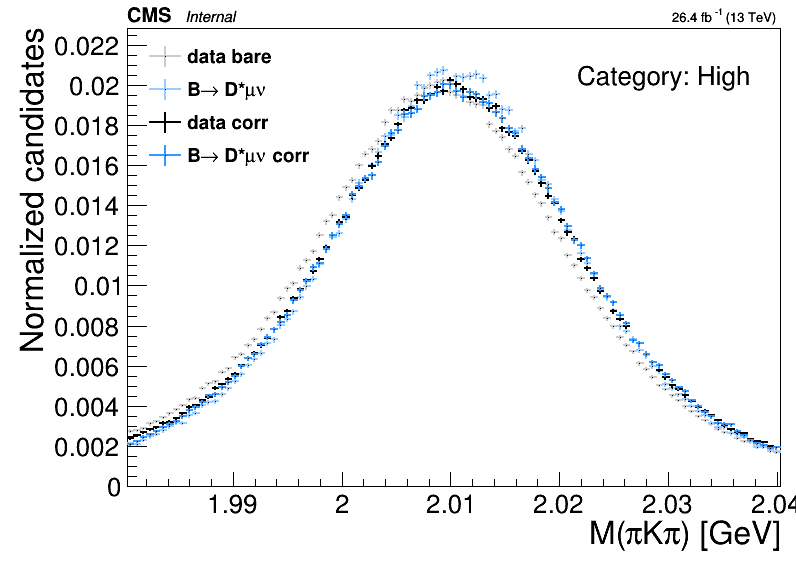

In [35]:
C = drawVar(varRD=dfRD_bare['mass_D0pis'],
            varMC=dfMC_bare['mass_D0pis'],
            varRDcorr=dfRD_corr['mass_D0pis'],
            varMCcorr=dfMC_corr['mass_D0pis'],
            binning=[100, m_Dst-0.03, m_Dst+0.03],  opt='',
            xtitle='M(#piK#pi) [GeV]')
C.SaveAs('../data/calibration/trackCorrections/fig/mDst_post_{}.png'.format(cat.name))

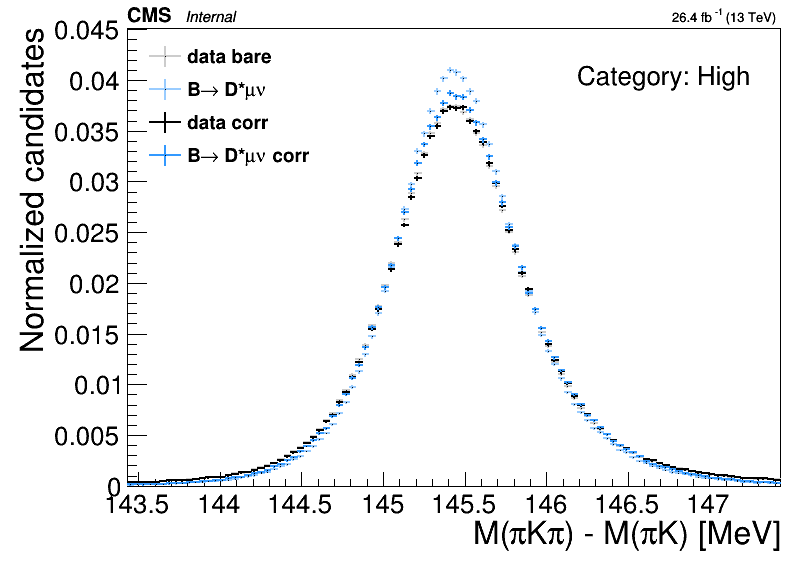

In [36]:
C = drawVar(varRD=1e3*(dfRD_bare['mass_D0pis'] - dfRD_bare['mass_piK']),
            varMC=1e3*(dfMC_bare['mass_D0pis'] - dfMC_bare['mass_piK']),
            varRDcorr=1e3*(dfRD_corr['mass_D0pis'] - dfRD_corr['mass_piK']),
            varMCcorr=1e3*(dfMC_corr['mass_D0pis'] - dfMC_corr['mass_piK']),
            binning=[100, 1e3*dm - 2, 1e3*dm + 2], 
            xtitle='M(#piK#pi) - M(#piK) [MeV]')
C.SaveAs('../data/calibration/trackCorrections/fig/dm_post_{}.png'.format(cat.name))

### Mass in different regions

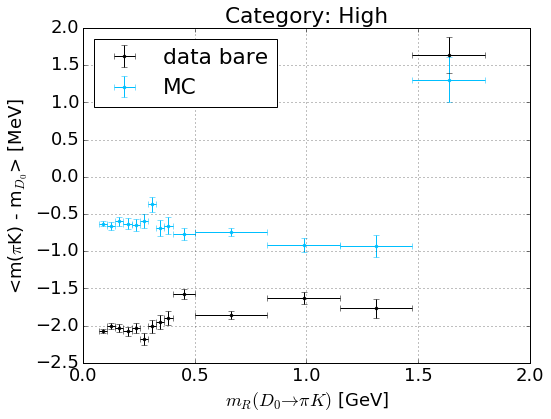

In [37]:
bins = np.concatenate((np.linspace(0.07, 0.4, 10), np.linspace(0.5, 1.8, 5)))

draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], None, 
             compute_mR(dfRD_bare), compute_mR(dfMC_corr), None,
             bins, r'$m_R(D_0\to \pi K)$ [GeV]')
plt.title('Category: ' + cat.name)
plt.savefig('../data/calibration/trackCorrections/fig/dm_vs_mR_pre_{}.png'.format(cat.name), bbox_inches='tight')

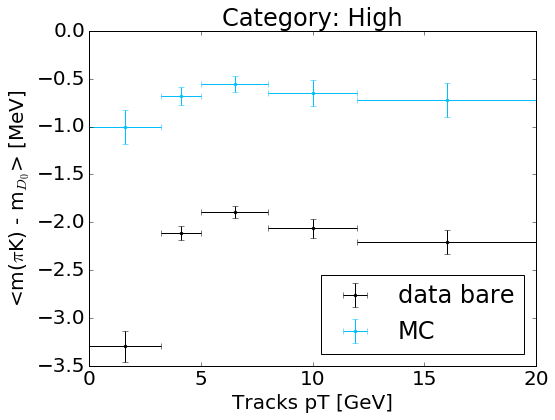

In [38]:
binsPt = np.array([0, 3.2, 5, 8, 12, 20])
avgRD = []
avgRDcorr = []
avgMC = []

for i in range(len(binsPt)-1):
    mpt = binsPt[i]
    Mpt = binsPt[i+1]
    selm = np.logical_and(dfRD_bare['pi_pt']>mpt, dfRD_bare['K_pt']>mpt)
    selM = np.logical_and(dfRD_bare['pi_pt']<Mpt, dfRD_bare['K_pt']<Mpt)    
    selRD = np.logical_and(selm, selM)
    avgRD.append(getAvg(dfRD_bare['mass_piK'][selRD]))
    
    selm = np.logical_and(dfRD_corr['pi_pt']>mpt, dfRD_corr['K_pt']>mpt)
    selM = np.logical_and(dfRD_corr['pi_pt']<Mpt, dfRD_corr['K_pt']<Mpt)    
    selRD = np.logical_and(selm, selM)
    avgRDcorr.append(getAvg(dfRD_corr['mass_piK'][selRD]))
    
    selm = np.logical_and(dfMC_bare['pi_pt']>mpt, dfMC_bare['K_pt']>mpt)
    selM = np.logical_and(dfMC_bare['pi_pt']<Mpt, dfMC_bare['K_pt']<Mpt)    
    selMC = np.logical_and(selm, selM)
    avgMC.append(getAvg(dfMC_bare['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgRDcorr = 1e3*np.array(avgRDcorr)
avgMC = 1e3*np.array(avgMC)

x = (binsPt[1:] + binsPt[:-1])/2.
dx = (binsPt[1:] - binsPt[:-1])/2.
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.plot(binsPt, [0]*len(binsPt), 'm--', lw=2)
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='data bare', color='black')
# plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', color='black', label='RD corr')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC', color='deepskyblue')
plt.legend(loc='best', numpoints=1)
plt.xlabel('Tracks pT [GeV]')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
plt.title('Category: ' + cat.name)
plt.savefig('../data/calibration/trackCorrections/fig/dm_vs_pt_pre_{}.png'.format(cat.name), bbox_inches='tight')

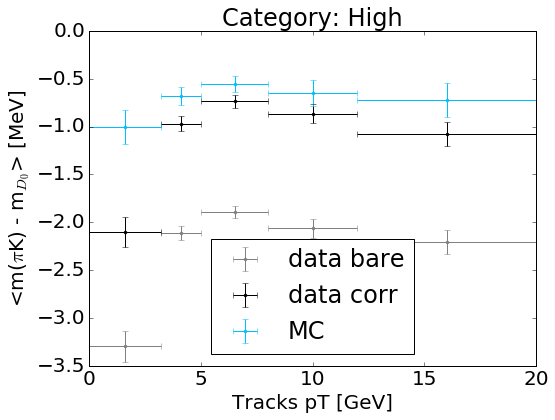

In [39]:
f = plt.figure(figsize=(8,6))
plt.plot(binsPt, [0]*len(binsPt), 'm--', lw=2)
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='data bare', color='gray')
plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', color='black', label='data corr')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC', color='deepskyblue')
plt.legend(loc='best', numpoints=1)
plt.xlabel('Tracks pT [GeV]')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')
plt.title('Category: ' + cat.name)
plt.savefig('../data/calibration/trackCorrections/fig/dm_vs_pt_post_{}.png'.format(cat.name), bbox_inches='tight')

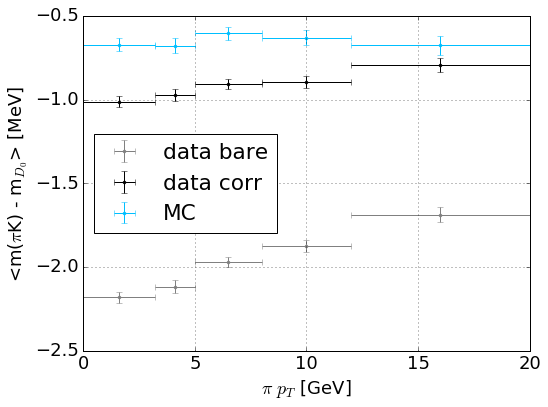

In [40]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             dfRD_bare['pi_pt'], dfMC_corr['pi_pt'], dfRD_corr['pi_pt'],
             binsPt, r'$\pi\ p_T$ [GeV]')

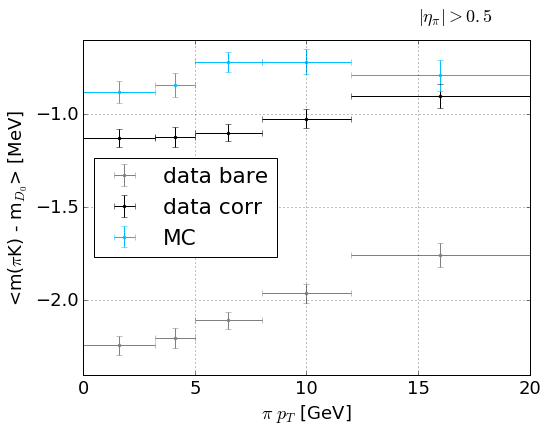

In [41]:
selRD = np.abs(dfRD_bare['pi_eta']) > 0.5
selMC = np.abs(dfMC_corr['pi_eta']) > 0.5
selRDcorr = np.abs(dfRD_corr['pi_eta']) > 0.5
draw_dM_vs_x(dfRD_bare['mass_piK'][selRD], dfMC_corr['mass_piK'][selMC], dfRD_corr['mass_piK'][selRDcorr], 
             dfRD_bare['pi_pt'][selRD], dfMC_corr['pi_pt'][selMC], dfRD_corr['pi_pt'][selRDcorr],
             binsPt, r'$\pi\ p_T$ [GeV]')

plt.text(15, -0.5, r'$|\eta_\pi| > 0.5$')

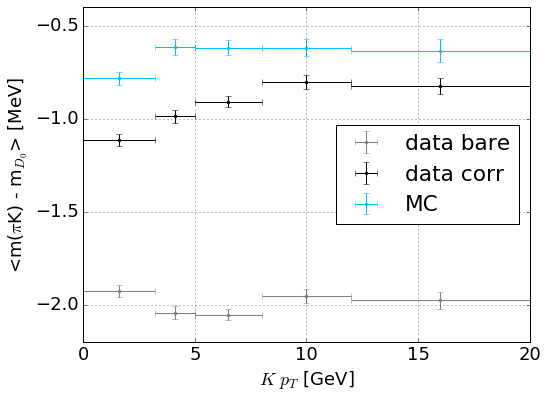

In [42]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             dfRD_bare['K_pt'], dfMC_corr['K_pt'], dfRD_corr['K_pt'],
             binsPt, r'$K\ p_T$ [GeV]')

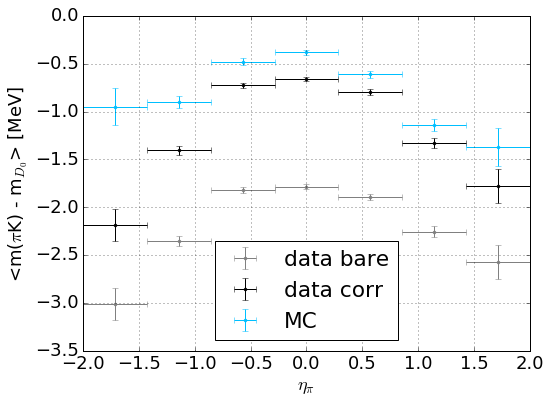

In [43]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             dfRD_bare['pi_eta'], dfMC_corr['pi_eta'], dfRD_corr['pi_eta'],
             np.linspace(-2, 2, 8), r'$\eta_\pi$')

In [44]:
# draw_dM_vs_x(df['mass_piK'], df_MC['mass_piK'], m_piK_RDcorr, df['K_eta'], df_MC['K_eta'], np.linspace(-2, 2, 8), r'$\eta_K$')

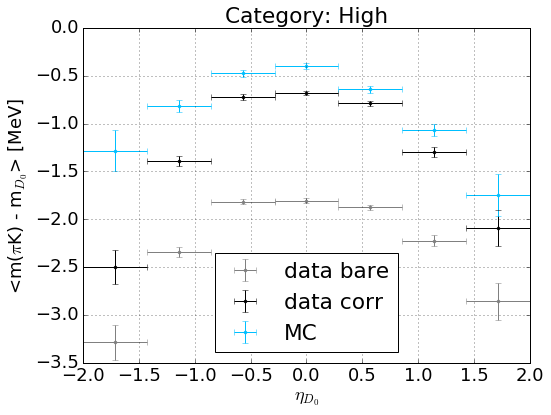

In [45]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             dfRD_bare['D0_eta'], dfMC_corr['D0_eta'], dfRD_corr['D0_eta'],
             np.linspace(-2, 2, 8), r'$\eta_{D_0}$')
plt.title('Category: ' + cat.name)
plt.savefig('../data/calibration/trackCorrections/fig/dm_vs_eta_post_{}.png'.format(cat.name), bbox_inches='tight')

In [46]:
# draw_dM_vs_x(df['mass_piK'], df_MC['mass_piK'], m_piK_RDcorr, df['D0_phi'], df_MC['D0_phi'], np.linspace(-4, 4, 8), r'$D_0\ \phi$ [rad]')

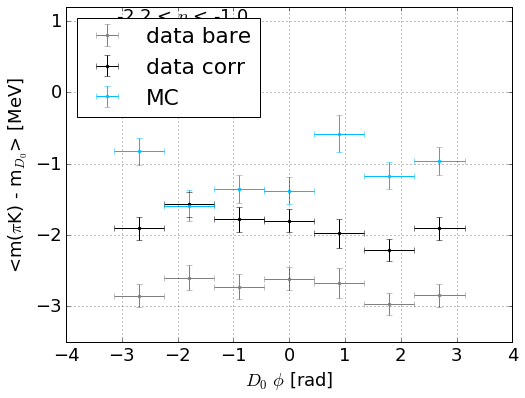

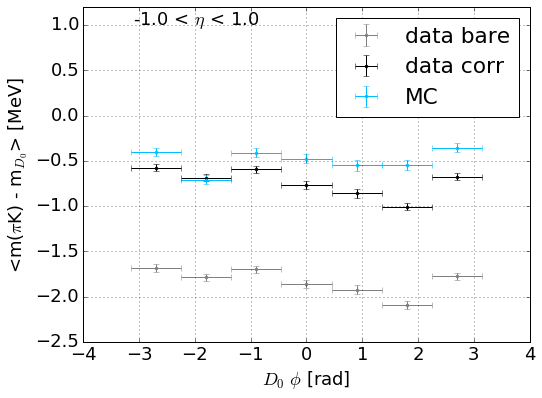

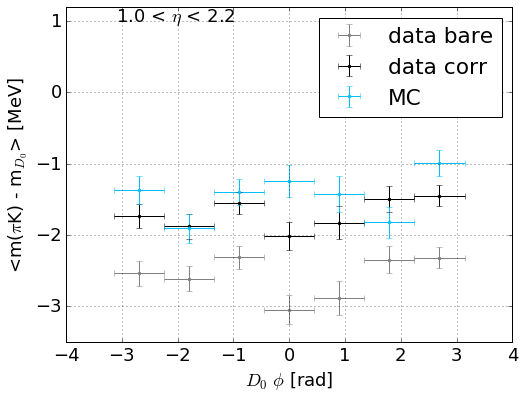

In [47]:
etaBins = [-2.2, -1, 1., 2.2]
for ie, (em, eM) in enumerate(zip(etaBins[:-1], etaBins[1:])):
    selEtaRDcorr = np.logical_and(dfRD_corr['D0_eta'] > em, dfRD_corr['D0_eta'] < eM)
    selEtaRDbare = np.logical_and(dfRD_bare['D0_eta'] > em, dfRD_bare['D0_eta'] < eM)
    selEtaMCcorr = np.logical_and(dfMC_corr['D0_eta'] > em, dfMC_corr['D0_eta'] < eM)
    selEtaMCbare = np.logical_and(dfMC_bare['D0_eta'] > em, dfMC_bare['D0_eta'] < eM)
    draw_dM_vs_x(dfRD_bare['mass_piK'][selEtaRDbare],
                 dfMC_corr['mass_piK'][selEtaMCcorr],
                 dfRD_corr['mass_piK'][selEtaRDcorr],
                 dfRD_bare['D0_phi'][selEtaRDbare], 
                 dfMC_corr['D0_phi'][selEtaMCcorr],
                 dfRD_corr['D0_phi'][selEtaRDcorr], 
                 bins=np.linspace(-np.pi, np.pi, 8), 
                 xlabel=r'$D_0\ \phi$ [rad]')
    plt.ylim(plt.ylim()[0], 1.2)
    plt.text(-3.1, 1.0, '{:.1f} < $\eta$ < {:.1f}'.format(em, eM))

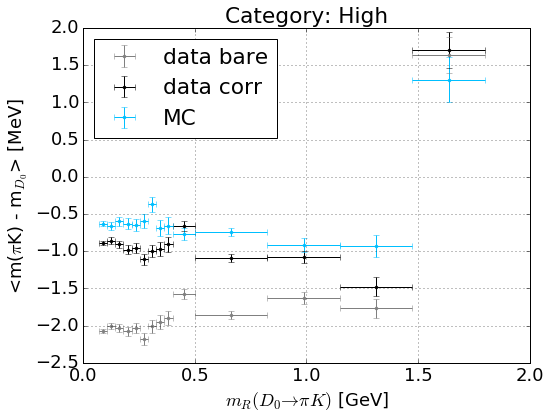

In [48]:
bins = np.concatenate((np.linspace(0.07, 0.4, 10), np.linspace(0.5, 1.8, 5)))

draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             compute_mR(dfRD_bare), compute_mR(dfMC_corr), compute_mR(dfRD_corr),
             bins, r'$m_R(D_0\to \pi K)$ [GeV]')
plt.title('Category: ' + cat.name)
plt.savefig('../data/calibration/trackCorrections/fig/dm_vs_mR_post_{}.png'.format(cat.name), bbox_inches='tight')

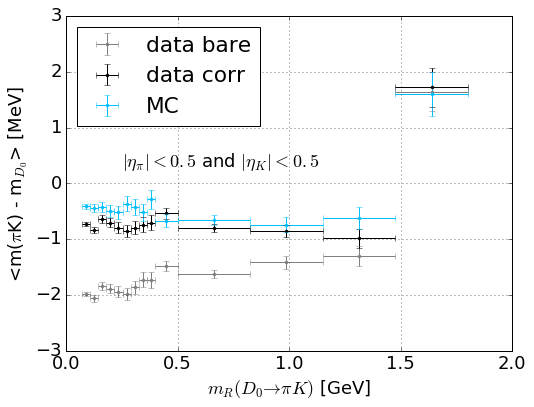

In [49]:
selRD = np.logical_and(np.abs(dfRD_bare['pi_eta']) < 0.5, np.abs(dfRD_bare['K_eta']) < 0.5)
selMC = np.logical_and(np.abs(dfMC_corr['pi_eta']) < 0.5, np.abs(dfMC_corr['K_eta']) < 0.5)
selRDcorr = np.logical_and(np.abs(dfRD_corr['pi_eta']) < 0.5, np.abs(dfRD_corr['K_eta']) < 0.5)
draw_dM_vs_x(dfRD_bare['mass_piK'][selRD], dfMC_corr['mass_piK'][selMC], dfRD_corr['mass_piK'][selRDcorr], 
             compute_mR(dfRD_bare)[selRD], compute_mR(dfMC_corr)[selMC], compute_mR(dfRD_corr)[selRDcorr],
             bins, r'$m_R(D_0\to \pi K)$ [GeV]')

plt.text(0.25, 0.3, r'$|\eta_\pi| < 0.5$ and $|\eta_K| < 0.5$')

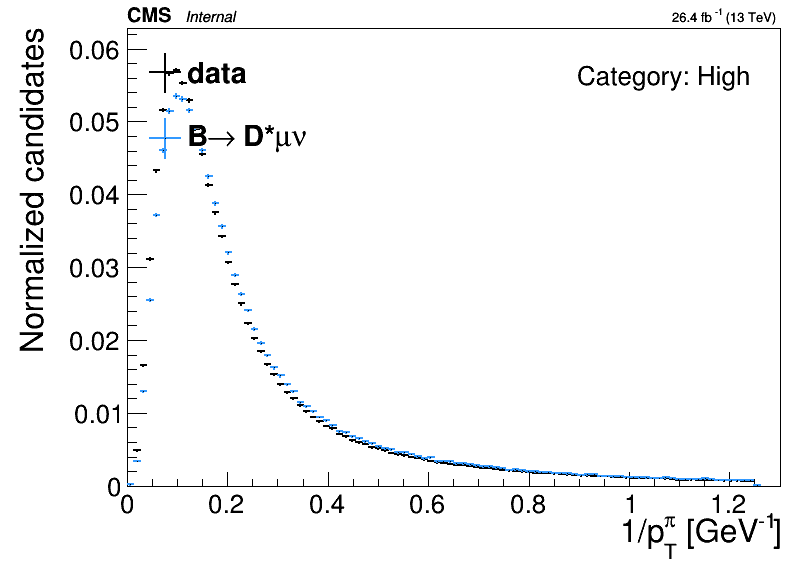

In [50]:
C = drawVar(varRD=1./dfRD_bare['pi_pt'],
            varMC=1./dfMC_bare['pi_pt'],
            binning=[100, 0, 1.3], 
            xtitle='1/p_{T}^{#pi} [GeV^{-1}]')

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-gnimlf/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


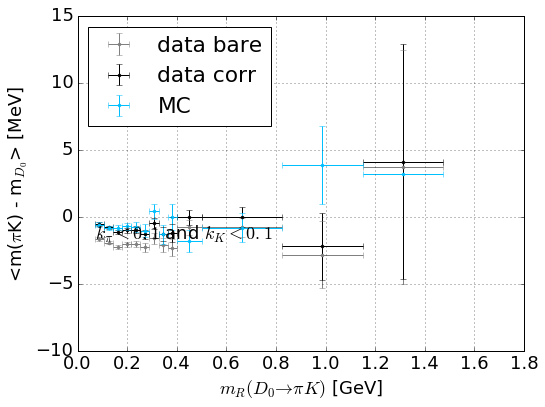

In [51]:
selRD = np.logical_and(np.abs(dfRD_bare['pi_pt']) > 10, np.abs(dfRD_bare['K_pt']) > 10)
selMC = np.logical_and(np.abs(dfMC_corr['pi_pt']) > 10, np.abs(dfMC_corr['K_pt']) > 10)
selRDcorr = np.logical_and(np.abs(dfRD_corr['pi_pt']) > 10, np.abs(dfRD_corr['K_pt']) > 10)
draw_dM_vs_x(dfRD_bare['mass_piK'][selRD], dfMC_corr['mass_piK'][selMC], dfRD_corr['mass_piK'][selRDcorr], 
             compute_mR(dfRD_bare)[selRD], compute_mR(dfMC_corr)[selMC], compute_mR(dfRD_corr)[selRDcorr],
             bins, r'$m_R(D_0\to \pi K)$ [GeV]')

plt.text(0.07, -1.7, r'$k_\pi < 0.1 $ and $k_K < 0.1$')

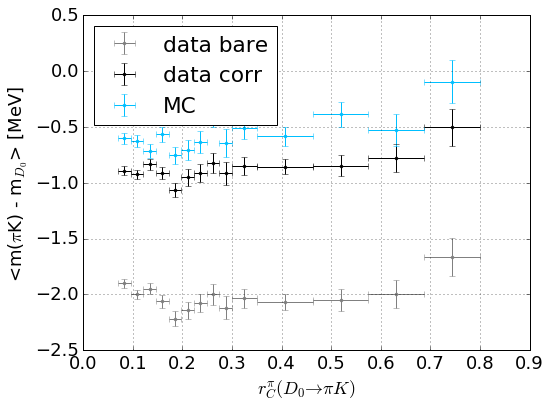

In [52]:
bins = np.concatenate((np.linspace(0.07, 0.3, 10), np.linspace(0.35, 0.8, 5)))

draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             compute_rC(dfRD_bare)[:,0], compute_rC(dfMC_corr)[:,0], compute_rC(dfRD_corr)[:,0],
             bins, r'$r_C^\pi(D_0\to \pi K)$')

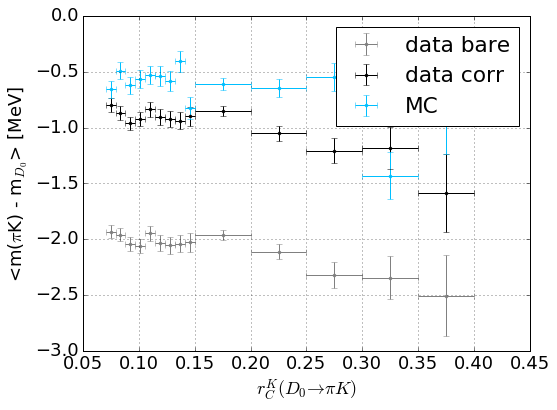

In [53]:
bins = np.concatenate((np.linspace(0.07, 0.15, 10), np.linspace(0.2, 0.4, 5)))

draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_corr['mass_piK'], dfRD_corr['mass_piK'], 
             compute_rC(dfRD_bare)[:,1], compute_rC(dfMC_corr)[:,1], compute_rC(dfRD_corr)[:,1],
             bins, r'$r_C^K(D_0\to \pi K)$')

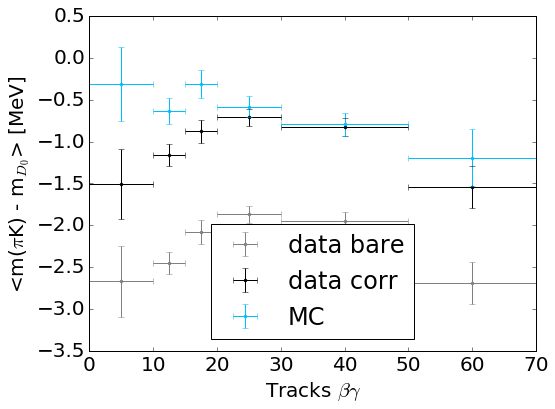

In [54]:
binsBG = np.array([0, 10, 15, 20, 30, 50, 70])
bgMC = np.column_stack((dfMC_bare['pi_pt']*np.cosh(dfMC_bare['pi_eta'])/m_pi, dfMC_bare['K_pt']*np.cosh(dfMC_bare['K_eta'])/m_K))
bgRD = np.column_stack((dfRD_bare['pi_pt']*np.cosh(dfRD_bare['pi_eta'])/m_pi, dfRD_bare['K_pt']*np.cosh(dfRD_bare['K_eta'])/m_K))
bgRD_corr = np.column_stack((dfRD_corr['pi_pt']*np.cosh(dfRD_corr['pi_eta'])/m_pi, dfRD_corr['K_pt']*np.cosh(dfRD_corr['K_eta'])/m_K))

avgRD = []
avgRDcorr = []
avgMC = []

for i in range(len(binsBG)-1):
    m = binsBG[i]
    M = binsBG[i+1]
    selm = np.logical_and(bgRD[:,0]>m, bgRD[:,1]>m)
    selM = np.logical_and(bgRD[:,0]<M, bgRD[:,1]<M)    
    selRD = np.logical_and(selm, selM)
    avgRD.append(getAvg(dfRD_bare['mass_piK'][selRD]))
    selm = np.logical_and(bgRD_corr[:,0]>m, bgRD_corr[:,1]>m)
    selM = np.logical_and(bgRD_corr[:,0]<M, bgRD_corr[:,1]<M)    
    selRD = np.logical_and(selm, selM)
    avgRDcorr.append(getAvg(dfRD_corr['mass_piK'][selRD]))
    
    selm = np.logical_and(bgMC[:,0]>m, bgMC[:,1]>m)
    selM = np.logical_and(bgMC[:,0]<M, bgMC[:,1]<M)    
    selMC = np.logical_and(selm, selM)
    avgMC.append(getAvg(dfMC_bare['mass_piK'][selMC]))

avgRD = 1e3*np.array(avgRD)
avgRDcorr = 1e3*np.array(avgRDcorr)
avgMC = 1e3*np.array(avgMC)

x = (binsBG[1:] + binsBG[:-1])/2.
dx = (binsBG[1:] - binsBG[:-1])/2.
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
plt.errorbar(x, avgRD[:,0]-1e3*m_D0, yerr=avgRD[:,1], xerr=dx, fmt='.', label='data bare', color='gray')
plt.errorbar(x, avgRDcorr[:,0]-1e3*m_D0, yerr=avgRDcorr[:,1], xerr=dx, fmt='.', label='data corr', color='black')
plt.errorbar(x, avgMC[:,0]-1e3*m_D0, yerr=avgMC[:,1], xerr=dx, fmt='.', label='MC', color='deepskyblue')
plt.legend(loc='best', numpoints=1)
plt.xlabel(r'Tracks $\beta \gamma$')
plt.ylabel('<m($\pi$K) - m$_{D_0}$> [MeV]')

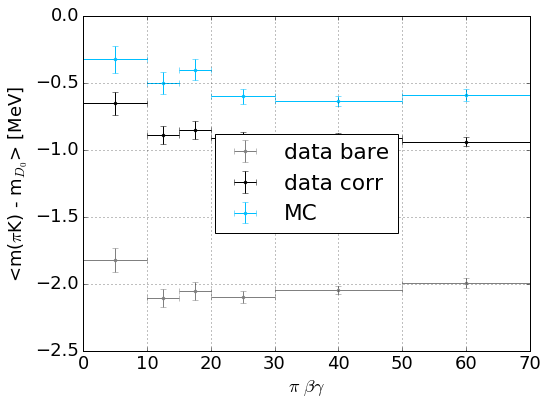

In [55]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_bare['mass_piK'], dfRD_corr['mass_piK'], 
             bgRD[:,0], bgMC[:,0], bgRD_corr[:,0],
             binsBG, r'$\pi\ \beta \gamma$')

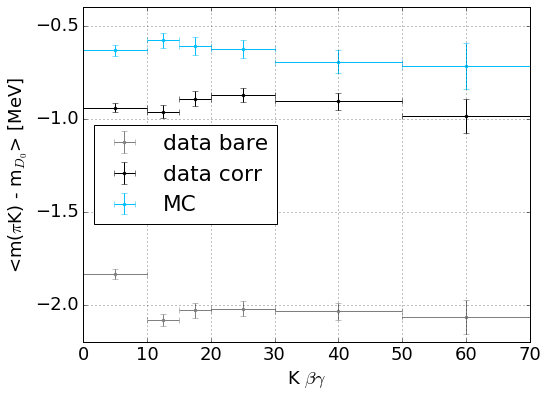

In [56]:
draw_dM_vs_x(dfRD_bare['mass_piK'], dfMC_bare['mass_piK'], dfRD_corr['mass_piK'], 
             bgRD[:,1], bgMC[:,1], bgRD_corr[:,1],
             binsBG, r'K $\beta \gamma$')

# Fit variables distributions

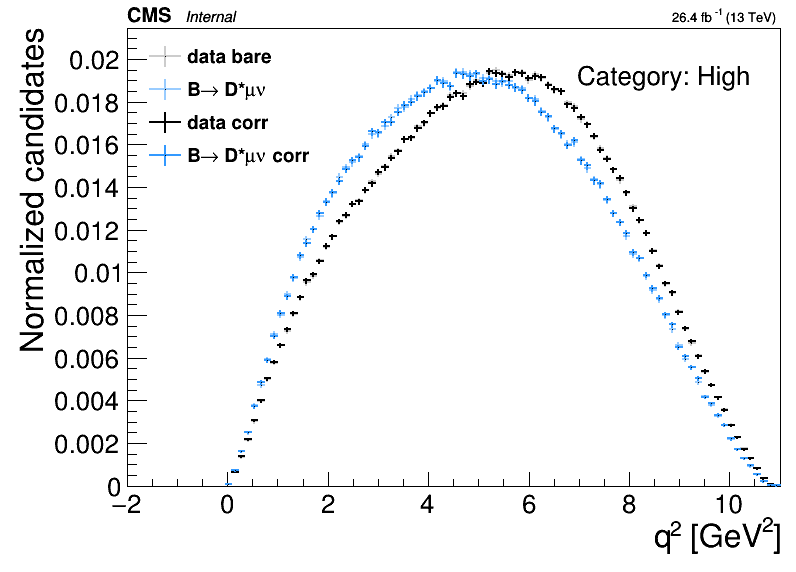

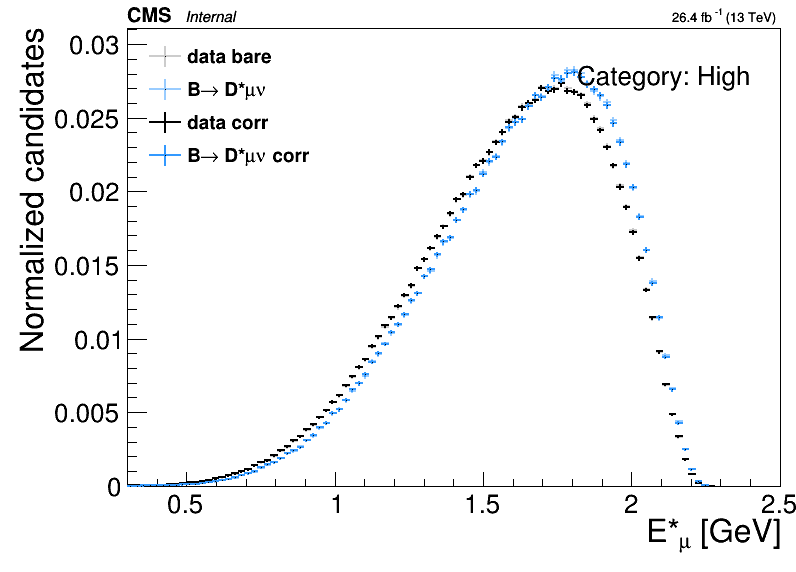

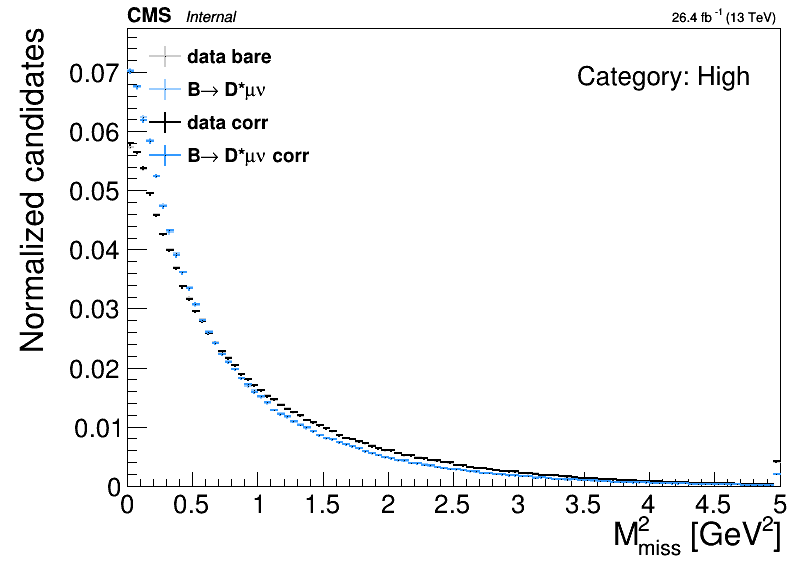

In [57]:
variables = ['q2', 'Est_mu', 'M2_miss']
axis_title = ['q^{2} [GeV^{2}]', 'E*_{#mu} [GeV]', 'M^{2}_{miss} [GeV^{2}]']
binnings = [[100, -2, 11.], [100, 0.3, 2.5], [100, 0, 5]]
dnd = []
for var, a, b in zip(variables, axis_title, binnings):
    C = drawVar(varRD=dfRD_bare[var],
                varMC=dfMC_bare[var],
                varRDcorr=dfRD_corr[var],
                varMCcorr=dfMC_corr[var],
                binning=b, 
                xtitle=a, cTag='c_'+var)
    dnd.append(C)
    C.SaveAs('../data/calibration/trackCorrections/fig/trkCorrComparison_{}_{}.png'.format(var, catName))